# Ensemble Kalman Filters

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

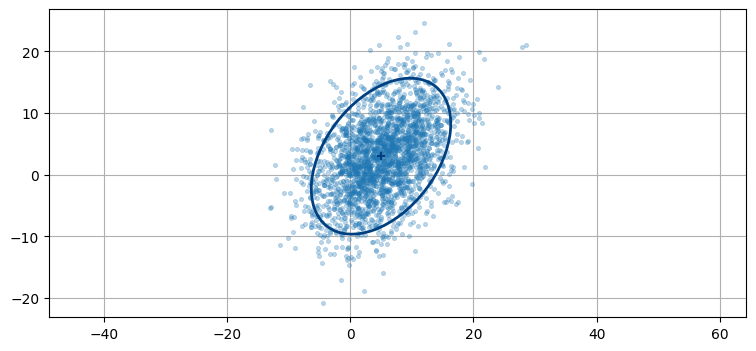

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import multivariate_normal
from filterpy.stats import (covariance_ellipse, 
                            plot_covariance_ellipse)

mean = (5, 3)
P = np.array([[32, 15],
              [15., 40.]])

x,y = multivariate_normal(mean=mean, cov=P, size=2500).T
plt.scatter(x, y, alpha=0.3, marker='.')
plt.axis('equal')

plot_covariance_ellipse(mean=mean, cov=P,
                        variance=2.**2,
                        facecolor='none')

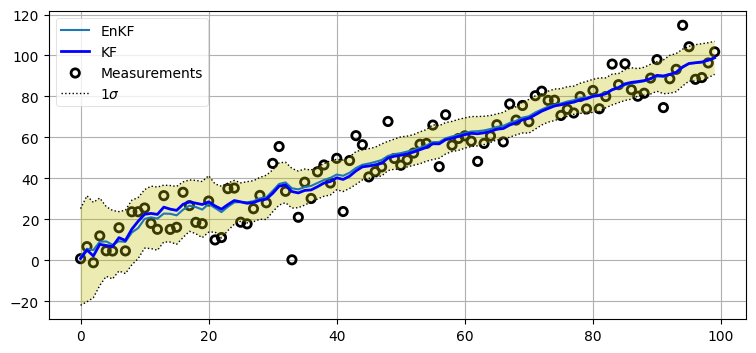

In [4]:
import kf_book.book_plots as bp
from numpy.random import randn
from filterpy.kalman import EnsembleKalmanFilter as EnKF
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

np.random.seed(1234)

def hx(x):
    return np.array([x[0]])

def fx(x, dt):
    return F @ x
    
F = np.array([[1., 1.],[0., 1.]])

x = np.array([0., 1.])
P = np.eye(2) * 100.
enf = EnKF(x=x, P=P, dim_z=1, dt=1., N=20, hx=hx, fx=fx)

std_noise = 10.
enf.R *= std_noise**2
enf.Q = Q_discrete_white_noise(2, 1., .001)

kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([x]).T
kf.F = F.copy()
kf.P = P.copy()
kf.R = enf.R.copy()
kf.Q = enf.Q.copy()
kf.H = np.array([[1., 0.]])

measurements = []
results = []
ps = []
kf_results = []

zs = []
for t in range (0,100):
    # create measurement = t plus white noise
    z = t + randn()*std_noise
    zs.append(z)

    enf.predict()
    enf.update(np.asarray([z]))
    
    kf.predict()
    kf.update(np.asarray([[z]]))

    # save data
    results.append (enf.x[0])
    kf_results.append (kf.x[0,0])
    measurements.append(z)
    ps.append(3*(enf.P[0,0]**.5))

results = np.asarray(results)
ps = np.asarray(ps)

plt.plot(results, label='EnKF')
plt.plot(kf_results, label='KF', c='b', lw=2)
bp.plot_measurements(measurements)
plt.plot (results - ps, c='k',linestyle=':', lw=1, label='1$\sigma$')
plt.plot(results + ps, c='k', linestyle=':', lw=1)
plt.fill_between(range(100), results - ps, results + ps, facecolor='y', alpha=.3)
plt.legend(loc='best');